# Comparative Analysis
In this notebook, we compare ClaP with competitors regarding runtime.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from claspy.window_size import suss
from src.utils import load_tssb_datasets, load_datasets, load_has_datasets
from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let's choose a score for evaluation (F1, Covering, or AMI).

In [3]:
eval_score = "ami_score"

Let's load the scores from the different methods.

In [4]:
candidates = ["AutoPlait", "HDP-HSMM", "Time2State", "E2USD", "TICC", "ClaSP2Feat", "CLaP"]

datasets = ["TSSB", "UTSA", "HAS", "SKAB", "MIT-BIH"]  #   
methods, dfs = list(), list()

dataset_dfs = {}

for candidate_name in candidates:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []

    for d in datasets:
        part = pd.read_csv(f"../../experiments/state_detection/{d}_{file_name}",
                           usecols=["dataset", eval_score, "runtime"], compression="gzip")

        # Add ClaSP runtime
        if name in ("ClaSP2Feat", "CLaP"):
            clasp = pd.read_csv(f"../../experiments/segmentation/{d}_clasp.csv.gz", usecols=["dataset", "runtime"],
                                compression="gzip")
            part.runtime += clasp.runtime

        df.append(part)

    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()
df_runtimes = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

    df_runtimes["dataset"] = df.dataset
    df_runtimes[name] = df["runtime"]

df_runtimes.sort_values(by="dataset", inplace=True)
df_scores.sort_values(by="dataset", inplace=True)

df_scores.reset_index(drop=True, inplace=True)
df_runtimes.reset_index(drop=True, inplace=True)

df_runtimes

,dataset,AutoPlait,HDP-HSMM,Time2State,E2USD,TICC,ClaSP2Feat,CLaP
0,Adiac,0.231469,26.985555,92.383091,13.007893,21.631620,52.711209,43.079765
1,ArrowHead,0.398861,30.040992,103.002740,13.640399,14.230596,276.581182,41.465044
2,Beef,0.011955,26.410430,100.507395,12.556137,13.645551,236.912527,41.266727
3,BeetleFly,0.230486,43.838969,109.385878,13.477307,14.674741,712.113003,44.682183
4,BirdChicken,0.365450,42.919428,101.567442,13.283878,13.680609,728.663782,44.896971
5,CBF,0.365149,22.651844,103.758907,12.954672,18.182487,67.210227,40.172196
6,Cane,0.353663,78.694893,83.669253,8.999182,25.508983,35.402691,20.985158
7,Car,0.314569,36.993545,85.806850,14.122484,23.328285,177.606648,43.551784
8,Chinatown,0.005031,9.242528,2.655208,2.866457,1.749856,34.826087,32.468788
9,ChlorineConcentration,0.302766,110.917143,134.009395,13.728583,14.792285,2802.477692,37.893090


In [5]:
df_data = pd.concat([load_tssb_datasets(), load_datasets("UTSA"), load_has_datasets(), load_datasets("SKAB"), load_datasets("MIT-BIH")])
df_data["ts_len"] = df_data.time_series.apply(len)
df_data['window_size'] = df_data.time_series.apply(
    lambda t: suss(t) if t.ndim == 1 else int(np.mean([suss(td) for td in t.T])))
df_data.sort_values(by="dataset", inplace=True)
idx_sizes = np.argsort(df_data.ts_len).to_numpy()
assert len(idx_sizes) == len(df_runtimes)

Let's calculate the mean/median/std score.

In [6]:
(df_runtimes.iloc[:, 1:].sum(axis=0).sort_values(ascending=True) / 60 / 60).round(3)

AutoPlait       0.032
E2USD           1.034
Time2State     15.790
HDP-HSMM       18.892
TICC           27.758
CLaP          113.881
ClaSP2Feat    157.889
dtype: float64

In [7]:
(df_runtimes.iloc[:, 1:].median(axis=0).sort_values(ascending=True)).round(3)

AutoPlait       0.046
E2USD           8.185
ClaSP2Feat     26.321
CLaP           38.129
TICC           58.502
HDP-HSMM       71.957
Time2State    103.003
dtype: float64

In [8]:
# df_runtimes.CLaP.to_numpy()[113]

In [9]:
df_runtimes.iloc[:, 1:].std(axis=0).sort_values().round(3)

AutoPlait        0.469
E2USD            6.070
Time2State     210.097
HDP-HSMM       388.850
TICC           992.982
CLaP          7752.604
ClaSP2Feat    8096.885
dtype: float64

Let's compute the wins per method.

In [10]:
ranks = df_runtimes.iloc[:, 1:].rank(1, method='min', ascending=True)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [11]:
for mean, name in zip(means[args], df_runtimes.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

AutoPlait:wins=402 rank=1.0
E2USD:wins=2 rank=2.4
ClaSP2Feat:wins=0 rank=4.0
CLaP:wins=0 rank=4.2
TICC:wins=0 rank=5.0
HDP-HSMM:wins=1 rank=5.5
Time2State:wins=0 rank=5.9


Let's plot the CD diagram.

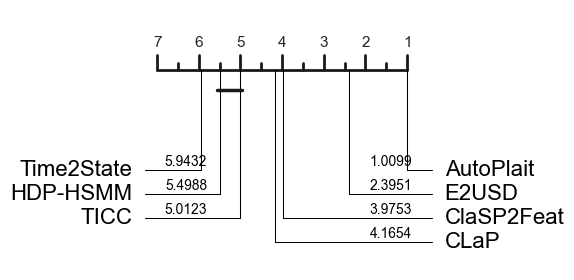

In [12]:
ax = plot_critical_difference(
    scores=df_runtimes.iloc[:, 1:].to_numpy(),
    labels=df_runtimes.columns[1:].to_numpy(),
    lower_better=True,
    alpha=0.05,
    width=5,
    textspace=1.5,
)

plt.savefig(f"../../figures/cd_state_detection_comparative_runtime.pdf", bbox_inches="tight")

Let's plot the MCM.

Processing CLaP, ClaSP2Feat:   0%|          | 0/7 [00:00<?, ?it/s]      


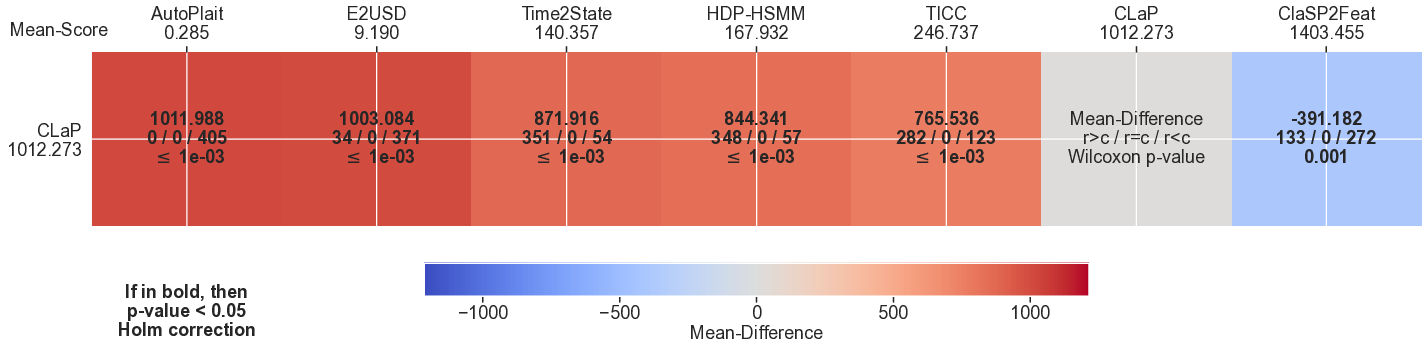

In [13]:
dir_path = "../../figures/"
file_name = f"mcm_state_detection_comparative_runtime"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_runtimes.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    order_WinTieLoss="lower",
    order_better="increasing",
    pvalue_correction="Holm",
    row_comparates=("CLaP",),
    fig_size=(20, 5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Let's compute wins/losses against CLaP.

In [14]:
selection = "CLaP"

for rival in df_runtimes.columns[1:]:
    if rival == selection: continue

    df_pair = df_runtimes[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=True)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

CLaP vs AutoPlait: (wins/ties/losses): 0/0/405
CLaP vs HDP-HSMM: (wins/ties/losses): 348/0/57
CLaP vs Time2State: (wins/ties/losses): 351/0/54
CLaP vs E2USD: (wins/ties/losses): 34/0/371
CLaP vs TICC: (wins/ties/losses): 282/0/123
CLaP vs ClaSP2Feat: (wins/ties/losses): 133/0/272


Let's compute plots for runtime analysis.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1865905154.py:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1865905154.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


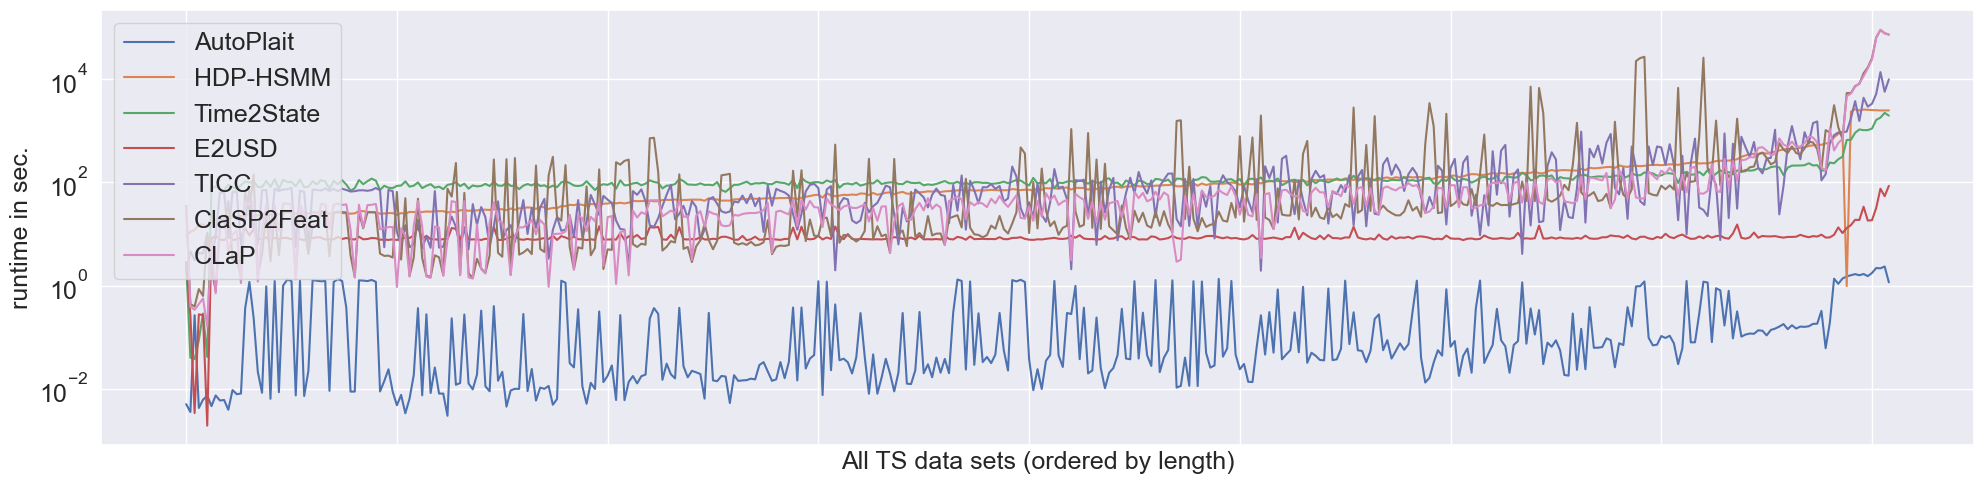

In [15]:
fontsize = 18
_, ax = plt.subplots(1, figsize=(20, 5))

for name in df_runtimes.columns[1:]:
    ax.plot(df_runtimes[name].to_numpy()[idx_sizes], label=name)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.tick_params(
    axis='x',
    which='both',
    labelbottom=False,
    labelleft=False
)
ax.legend(loc=2, prop={'size': fontsize})
ax.set_xlabel("All TS data sets (ordered by length)", fontsize=fontsize)
ax.set_ylabel("runtime in sec.", fontsize=fontsize)

ax.set_yscale('log')

names = df_runtimes.dataset.to_numpy().tolist()
names = np.array(names)[idx_sizes]

plt.savefig(f"../../figures/runtime.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1172306103.py:17: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1172306103.py:20: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


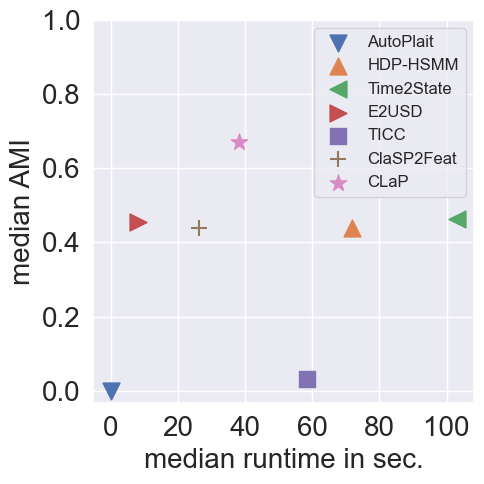

In [16]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 5))

markers = ["v", "^", "<", ">", "s", "+", "*"]

for competitor, marker in zip(df_runtimes.columns[1:], markers):
    ax.scatter(df_runtimes[competitor].median(), df_scores[competitor].median(), label=competitor, marker=marker, s=148)

ax.set_xlabel("median runtime in sec.", fontsize=fontsize)
ax.set_ylabel("median AMI", fontsize=fontsize)
ax.set_yticks(np.arange(0, 1.0+0.1, 0.2))

ax.legend(prop={'size': 12}, loc="upper right")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../../figures/runtime_ami.pdf", bbox_inches="tight")

Let's perform a scalability analysis.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3216499382.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3216499382.py:15: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


,ts_len,runtime
7,240,43.551784
213,340,77.392748
118,360,38.793802
172,443,10.053231
95,456,13.886362
67,471,17.037839
127,561,37.321092
164,730,84.651933
20,745,33.274147
21,780,32.254401


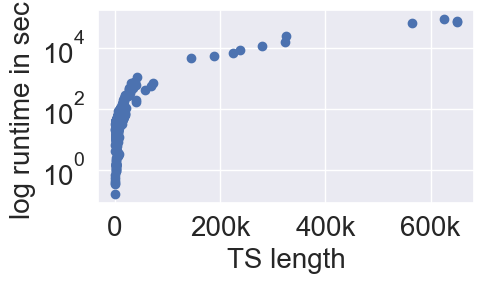

In [17]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_data.ts_len, df_runtimes.CLaP)
ax.set_xlabel("TS length", fontsize=fontsize)
ax.set_ylabel("log runtime in sec.", fontsize=fontsize)

ax.set_xticks(np.arange(0, 600_000+1, 200_000))
ax.set_xticklabels(["0", "200k", "400k", "600k"])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_yscale('log')

plt.savefig(f"../../figures/runtime_length.pdf", bbox_inches="tight")

df = pd.DataFrame()
df["ts_len"] = df_data.ts_len
df["runtime"] = df_runtimes.CLaP
df.sort_values(by="ts_len")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3999373979.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3999373979.py:14: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


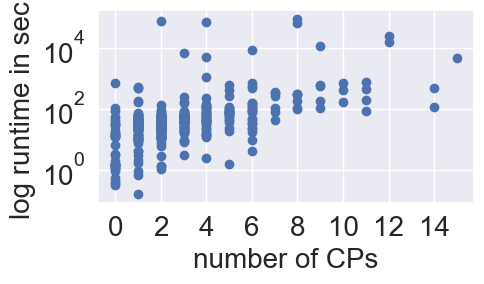

In [18]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_data["change_points"].apply(len), df_runtimes.CLaP)
ax.set_xlabel("number of CPs", fontsize=fontsize)
ax.set_ylabel("log runtime in sec.", fontsize=fontsize)

ax.set_xticks(np.arange(0, 15 + 1, 2))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_yscale('log')

plt.savefig(f"../../figures/runtime_cps.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3619216805.py:9: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/3619216805.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


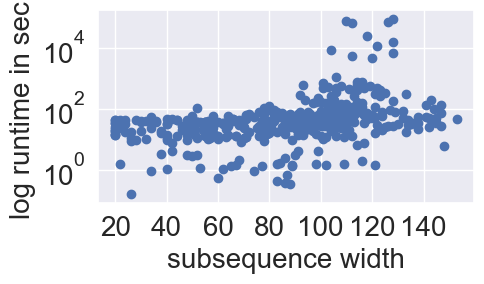

In [19]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_data.window_size, df_runtimes.CLaP)
ax.set_xlabel("subsequence width", fontsize=fontsize)
ax.set_ylabel("log runtime in sec.", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_yscale('log')

plt.savefig(f"../../figures/runtime_window.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1232292331.py:9: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_4596/1232292331.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


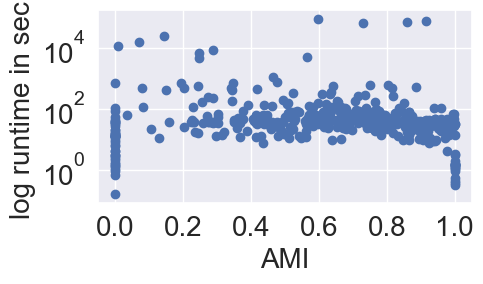

In [20]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_scores.CLaP, df_runtimes.CLaP)
ax.set_xlabel("AMI", fontsize=fontsize)
ax.set_ylabel("log runtime in sec.", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_yscale('log')

plt.savefig(f"../../figures/runtime_ami_scatter.pdf", bbox_inches="tight")

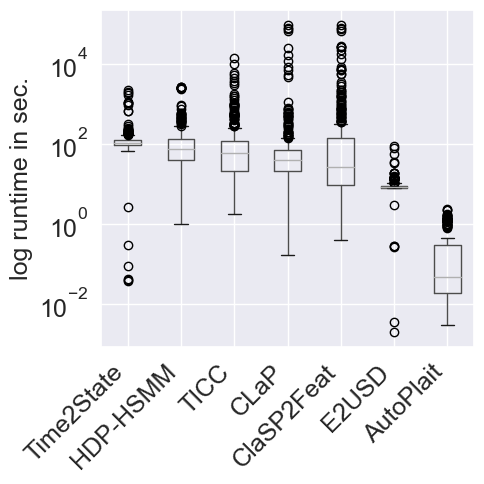

In [21]:
fontsize = 18
_, ax = plt.subplots(figsize=(5, 5))

# Sort by median performance
df_sorted_scores = df_runtimes[df_runtimes.iloc[:, 1:].median(axis=0).apply(lambda m: -m).sort_values().index] 

#df_sorted_scores.sum().plot.bar(ax=ax, rot=90)
df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel("log runtime in sec.", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yscale('log')

plt.savefig(f"../../figures/bp_state_detection_comparative_runtime.pdf", bbox_inches="tight")